In [19]:
import covid19sim
import pandas as pd
import numpy as np
import dill
from collections import defaultdict
import datetime
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("agg")
%matplotlib inline

## Risk to Recommendation level breaking behavior
People can be categorized in the following categories - 

Order 0: 
A - Human is exposed (can be carrying 0 viral load)
B - Human is infectious and pre-symptomatic (alsoincludes asymptomatic)
C - Human is infectious and symptomatic
D - Human is infectious and Tested Positive

Order 1:
Human is not infected but is one-hop away from (had a contact)
E - Exposed person
H - Pre-symptomatic Infectious
I - Symptomatic infectious 
J - Tested positive

K - All others!

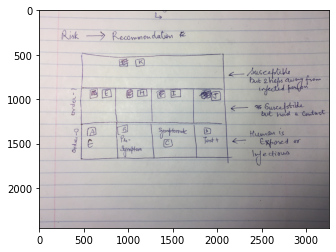

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("_RecBreakdown.png")
plt.imshow(image)
plt.show()

In [21]:
filename = "../src/covid19sim/logs4/tracker_data_n_200_seed_0_20200509-090220_.pkl"

In [4]:
data = dill.load(open(filename,"rb"))

In [6]:
risk_attributes = data['risk_attributes']
histograms_risk = defaultdict(list)
histograms_risk_level = defaultdict(list)
histograms_rec_level = defaultdict(list)
for x in risk_attributes:
    KEYS = []
    order_2 = True
    if x['exposed']:
        KEYS.append("A")
        order_2 = False
    
    if x['infectious'] and x['symptoms']==0:
        KEYS.append("B")
        order_2 = False
        
    if x['infectious'] and x['symptoms'] > 0:
        KEYS.append("C")
        order_2 = False
        
    if x['test']:
        KEYS.append("D")
        order_2 = False
        
    if x['order_1_is_exposed']:
        KEYS.append("E")
        order_2 = False
        
    if x['order_1_is_presymptomatic']:
        KEYS.append("H")
        order_2 = False
        
    if x['order_1_is_symptomatic']:
        KEYS.append("I")
        order_2 = False
        
    if x['order_1_is_tested']:
        KEYS.append("J")
        order_2 = False    
    
    if order_2:
        KEYS.append("K")

    for k in KEYS:    
        histograms_risk[k].append(x['risk'])
        histograms_risk_level[k].append(x['risk_level'])
        histograms_rec_level[k].append(x['rec_level'])

Text(0.5, 0.98, 'Risk values and the state of humans')

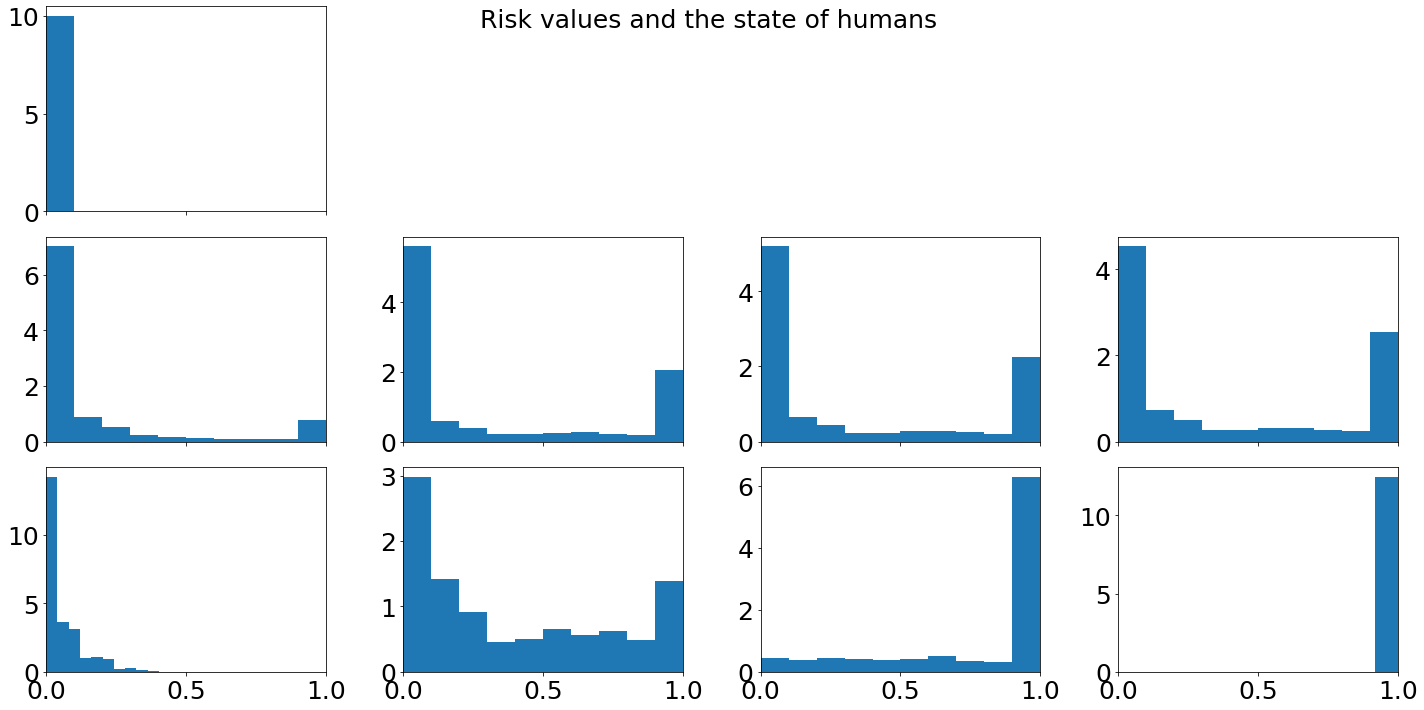

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,10), sharex=True)

def _plot(axs, histogram):
    axs.hist(histogram, density=True)
    axs.tick_params(labelsize=25)
    axs.set_xlim(0,1)
    
_plot(axs[2][0], histograms_risk["A"])
_plot(axs[2][1], histograms_risk["B"])
_plot(axs[2][2], histograms_risk["C"])
_plot(axs[2][3], histograms_risk["D"])

_plot(axs[1][0], histograms_risk["E"])
_plot(axs[1][1], histograms_risk["H"])
_plot(axs[1][2], histograms_risk["I"])
_plot(axs[1][3], histograms_risk["J"])

_plot(axs[0][0], histograms_risk["K"])
[x.set_visible(False) for x in axs[0][1:]]

plt.tight_layout()

fig.suptitle("Risk values and the state of humans", fontsize=25)




In [25]:
def load_histograms(data):
    risk_histogram, risk_level_histogram, rec_level_histogram = [], [], []
    risk_histogram_test_contact, risk_level_histogram_test_contact, rec_level_histogram_test_contact = [], [], []
    risk_histogram_symptom_contact, risk_level_histogram_symptom_contact, rec_level_histogram_symptoms_contact = [], [], []
    
    for timestamp in data['human_monitor']:
        for c,payload in enumerate(data['human_monitor'][timestamp]):
            infection_timestamp = payload['infection_timestamp']
            
            # values when human got infected
            if infection_timestamp.date() == timestamp.date():
                risk_histogram.append(payload['risk'])
                risk_level_histogram.append(payload['risk_level'])
                rec_level_histogram.append(payload['rec_level'])
            
            # values when human was notified of the any order positive test
            if sum(sum(x) for x in payload['test_orders'].values()) > 0:
                risk_histogram_test_contact.append(payload['risk'])
                risk_level_histogram_test_contact.append(payload['risk_level'])
                rec_level_histogram_test_contact.append(payload['rec_level'])
                
            # values when human was notified of the first order symptoms 
            # NOTE: TRACE_SYMPTOMS should be True or RISK_MODEL == "transformer"
            if sum(sum(x) for x in payload['symptom_orders'].values()) > 0:
                risk_histogram_symptom_contact.append(payload['risk'])
                risk_level_histogram_symptom_contact.append(payload['risk_level'])
                rec_level_histogram_symptom_contact.append(payload['rec_level'])
            
    humans = pd.DataFrame.from_dict(humans, orient="index")
    humans.index = pd.MultiIndex.from_tuples(humans.index)
    return humans

In [72]:
risk_histogram, risk_level_histogram, rec_level_histogram = [], [], []
risk_histogram_test_contact, risk_level_histogram_test_contact, rec_level_histogram_test_contact = [], [], []
risk_histogram_symptom_contact, risk_level_histogram_symptom_contact, rec_level_histogram_symptoms_contact = [], [], []
risk_histogram_test_contact_begin, risk_level_histogram_test_contact_begin,  rec_level_histogram_test_contact_begin = [], [], []
risk_histogram_symptom_contact_begin, risk_level_histogram_symptom_contact_begin, rec_level_histogram_symptom_contact_begin = [], [], []

human_recorded_test = set()
human_recorded_symptom = set()
for timestamp in data['human_monitor']:
    for c,payload in enumerate(data['human_monitor'][timestamp]):
        infection_timestamp = payload['infection_timestamp']
        
        # values when human got infected
        if infection_timestamp and infection_timestamp.date() == timestamp:
            risk_histogram.append(payload['risk'])
            risk_level_histogram.append(payload['risk_level'])
            rec_level_histogram.append(payload['rec_level'])

        # values when human was notified of the any order positive test 
        if sum(sum(x) for x in payload['test_orders'].values()) > 0:
            risk_histogram_test_contact.append(payload['risk'])
            risk_level_histogram_test_contact.append(payload['risk_level'])
            rec_level_histogram_test_contact.append(payload['rec_level'])
            
            # this records the 
            if c not in human_recorded_test:
                risk_histogram_test_contact_begin.append(payload['risk'])
                risk_level_histogram_test_contact_begin.append(payload['risk_level'])
                rec_level_histogram_test_contact_begin.append(payload['rec_level'])
                human_recorded_test.add(c)

        # values when human was notified of the first order symptoms 
        # NOTE: TRACE_SYMPTOMS should be True or RISK_MODEL == "transformer"
        if sum(sum(x) for x in payload['symptom_orders'].values()) > 0:
            risk_histogram_symptom_contact.append(payload['risk'])
            risk_level_histogram_symptom_contact.append(payload['risk_level'])
            rec_level_histogram_symptom_contact.append(payload['rec_level'])
            
            if c not in human_recorded_symptom:
                risk_histogram_symptom_contact_begin.append(payload['risk'])
                risk_level_histogram_symptom_contact_begin.append(payload['risk_level'])
                rec_level_histogram_symptom_contact_begin.append(payload['rec_level'])
                human_recorded_symptom.add(c)
                
                


In [73]:
len(risk_histogram), len(risk_histogram_test_contact_begin), len(risk_histogram_symptom_contact_begin)


(201, 163, 0)

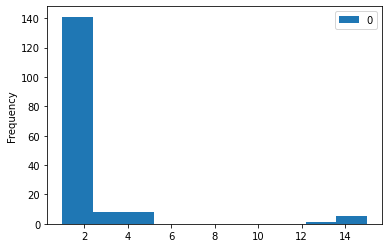

In [90]:
plt.figure()
plt.hist(risk_histogram, density=True, bins=30) 

pd.DataFrame(risk_level_histogram_test_contact_begin).plot.hist().get_figure()

In [26]:
humans = load_humans(data)
infection_chain = data['infection_monitor']
infector_infectee_update_messages = data['infector_infectee_update_messages']

In [28]:
infection_chain

[['human:132', 'human:133', datetime.date(2020, 3, 1)],
 ['human:147', 'human:145', datetime.date(2020, 3, 1)],
 ['human:123', 'human:122', datetime.date(2020, 3, 1)],
 ['human:8', 'human:39', datetime.date(2020, 3, 1)],
 ['human:147', 'human:143', datetime.date(2020, 3, 1)],
 ['human:123', 'human:121', datetime.date(2020, 3, 1)],
 [None, 'human:144', datetime.date(2020, 3, 2)],
 ['human:147', 'human:146', datetime.date(2020, 3, 3)],
 ['human:123', 'human:169', datetime.date(2020, 3, 3)],
 ['human:123', 'human:124', datetime.date(2020, 3, 4)],
 ['human:121', 'human:165', datetime.date(2020, 3, 4)],
 ['human:143', 'human:86', datetime.date(2020, 3, 4)],
 ['human:122', 'human:101', datetime.date(2020, 3, 4)],
 ['human:145', 'human:102', datetime.date(2020, 3, 4)],
 ['human:121', 'human:170', datetime.date(2020, 3, 5)],
 ['human:121', 'human:115', datetime.date(2020, 3, 5)],
 ['human:122', 'human:157', datetime.date(2020, 3, 5)],
 ['human:144', 'human:125', datetime.date(2020, 3, 6)],
 ['

In [47]:
pd.set_option('display.max_rows', None)
df = humans.loc[(slice(None), ("test_orders", "symptom_orders", "risk")), :]

In [51]:
df[np.where(df.loc[(slice(None), ("test_orders", "symptom_orders")),:] > 0)[1]]

5         9         13        28        42   \
2020-02-28 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-02-29 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-01 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-02 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-03 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-04 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-05 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-06 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-07 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-08 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-09 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-10 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-11 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-12 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-13 risk                0.01      0.01      0.01      0.01      0.01   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-14 risk                   0         0         0         0         0   
           test_orders           27         1         1         1         1   
           symptom_orders         0         0         0         0         0   
2020-03-15 risk                   0         0         0         0         0   
           test_orders           27         1         1         1         1   
   